In [4]:
import planetary_computer
import rasterio
#from pystac_client import Client
import glob, gzip, os, json, time
import cv2
import numpy as np
def showim(i):
    import matplotlib.pyplot as plt
    plt.imshow(i if len(i.shape) == 2 else i[:,:,:3][:,:,::-1])
    plt.axis("off")
    plt.show()
    
def show_jpg(im0, quality=95, width_perc=100):
    import base64, cv2
    import IPython.display
    _, encoded_img = cv2.imencode('.jpg', im0, [int(cv2.IMWRITE_JPEG_QUALITY), quality, int(cv2.IMWRITE_JPEG_SAMPLING_FACTOR), int(cv2.IMWRITE_JPEG_SAMPLING_FACTOR_444)])
    img_base64 = base64.b64encode(encoded_img).decode()
    style_txt = "width:{im0.shape[1]}px; height:{im0.shape[0]}px;" if width_perc <= 0 else f"width:{width_perc}%; height:auto;"
    IPython.display.display(IPython.display.HTML(f'<img src="data:image/jpeg;base64,{img_base64}" style="{style_txt}">'))

#root_url = "https://planetarycomputer.microsoft.com/api/stac/v1"
src_file = '/workspace/naip_dwnl/sids_meta.json.gz'
with gzip.open(src_file, "r") as f:
    sids_meta = json.load(f)
    
satlas_subdir = ['val_set','train_urban_set']
root_satlas_src = '/workspace/satlas/'

In [44]:
#calculate spatial resolution of a webmercator coordinate system
def meters_per_pixel(z=17, tile_size=128):
    earth_circumference = 2 * np.pi * 6378137
    return earth_circumference / (tile_size * 2 ** z)
print(meters_per_pixel(), "Zoom Faktor from 10m:", 10/meters_per_pixel())

2.388657133911758 Zoom Faktor from 10m: 4.1864526549373835


In [84]:
import tqdm.auto as tqdm
import mercantile
from rasterio.transform import from_bounds
from rasterio.warp import reproject, Resampling
import numpy as np


root_res_dir = '/workspace/naip_dwnl/nirres2/'
dst_width = dst_height = 128

calc_bandids = [0,1,2,3] #0,1,2->RGB; 3->NIR
save_nir, save_rgb = False, False

cntr_offs = 0 #seems to be no consistent shift (i.e. 0.5 center of pixel vs. 0 for NN)
resampling_method = Resampling.lanczos 
#resampling_method = Resampling.nearest 
#vis_result, max_vis =None, -1
vis_result, max_vis = {}, 3  #keep result for visualization

for i,tiles_key in enumerate(['tiles_val','tiles_train']):
    root_res_subdir = f'{root_res_dir}/{satlas_subdir[i]}/naip'
    orig_subdir = f'{root_satlas_src}/{satlas_subdir[i]}/naip'
    for k, v in tqdm.tqdm(sids_meta['tiles_val'].items()):
        full_tile_p = f'/workspace/naip_dwnl/tmpgeotiffs/{k}.tif'
        has_full = os.path.exists(full_tile_p)
        for t0 in v:
            orig_rgb = f'{orig_subdir}/{k}/{t0}/rgb.png'
            trg_nir = f'{root_res_subdir}/{k}/{t0}/nir.png'
            trg_rgb = f'{root_res_subdir}/{k}/{t0}/rgb.png'
            if os.path.exists(trg_nir):
                continue
            partial_tile_p = f'/workspace/naip_dwnl/val_tmptiffs/{k}_{t0}.tif'
            xy = [int(c) for c in t0.split('_')]
            left, bottom, right, top = mercantile.xy_bounds(xy[0],xy[1],17)# all satlas coords are of z==17
            dst_transform = from_bounds(left+cntr_offs, bottom-cntr_offs, right+cntr_offs, top-cntr_offs, dst_width, dst_height)
            load_path = full_tile_p if has_full else partial_tile_p
            #try:
            if True:
                with rasterio.Env():
                    with rasterio.open(load_path) as src:
                        dst_array = np.zeros((src.count, dst_height, dst_width), dtype=np.float32)
                        for i in calc_bandids:
                            reproject(  source=rasterio.band(src, i + 1),
                                        destination=dst_array[i],
                                        src_transform=src.transform,
                                        src_crs=src.crs,
                                        dst_transform=dst_transform,
                                        dst_crs="EPSG:3857",  # destination is in Web Mercator
                                        resampling=resampling_method    # or cubic, lanczos, etc.
                                    )
                        dst_array = np.ascontiguousarray(np.transpose(np.uint8(np.clip(np.round(dst_array),0,255)),(1,2,0)))

                        dst_rgb = dst_array[:,:,:3][:,:,::-1]
                        dst_nir = dst_array[:,:,3]
                        
                        if not vis_result is None:
                            vis_result[orig_rgb] = dst_array

                        if save_nir:
                            os.makedirs(os.path.dirname(trg_nir),exist_ok=True)
                            cv2.imwrite(trg_nir, dst_rgb)
                        if save_rgb:
                            os.makedirs(os.path.dirname(trg_rgb),exist_ok=True)
                            cv2.imwrite(trg_rgb, dst_nir)
            #except:
            #    pass
        if len(vis_result) >= max_vis:
            break
    if len(vis_result) >= max_vis:
        break

  0%|          | 0/7688 [00:00<?, ?it/s]

In [35]:
#check that 100% of data was generated
all_rgb_paths = []
for d in ['/workspace/satlas/val_set', '/workspace/satlas/train_urban_set']:
    all_rgb_paths += glob.glob(d+'/naip/**/rgb.png', recursive=True)
rgb_data = set([p.replace('/workspace/satlas/','').replace('rgb.png','') for p in all_rgb_paths])
all_nir_paths = []
for d in ['/workspace/naip_dwnl/nirres/val_set', '/workspace/naip_dwnl/nirres/train_urban_set']:
    all_nir_paths += glob.glob(d+'/naip/**/nir.png', recursive=True)
nir_data = set([p.replace('/workspace/naip_dwnl/nirres/','').replace('nir.png','') for p in all_nir_paths])
missing = rgb_data.difference(nir_data)
assert len(missing) == 0

In [58]:
#diff for RGB vs satlas distributed rgb
calc_diff = []
for k, v in vis_result.items():                
    orig_bgr = cv2.imread(k)
    calc_diff.append(np.mean(np.abs(np.float32(orig_bgr)-np.float32(v[:,:,:3][:,:,::-1]))))
print(np.mean(calc_diff))

2.9076538


Results for resampling_method: Resampling.nearest
/workspace/satlas//val_set/naip/m_2408115_sw_17_060_20191128/35956_56214/rgb.png (128, 128, 3) (128, 128, 4)



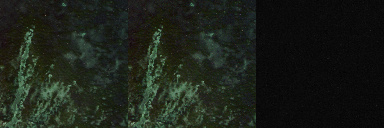

/workspace/satlas//val_set/naip/m_2408122_ne_17_060_20191128/35944_56235/rgb.png (128, 128, 3) (128, 128, 4)



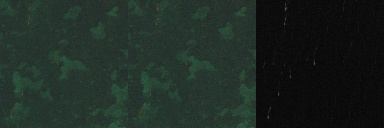

/workspace/satlas//val_set/naip/m_2408127_ne_17_060_20191128/35803_56299/rgb.png (128, 128, 3) (128, 128, 4)



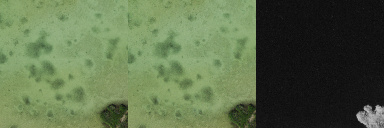

In [83]:
print("Results for resampling_method:", resampling_method)
for k, v in vis_result.items():
    orig_bgr = cv2.imread(k)
    show_nir = cv2.cvtColor(v[:,:,3], cv2.COLOR_GRAY2BGR)
    show_line = np.hstack([orig_bgr,v[:,:,:3][:,:,::-1], show_nir])
    print(k, orig_bgr.shape, v.shape)
    show_jpg(show_line)

Results for resampling_method: Resampling.lanczos
/workspace/satlas//val_set/naip/m_2408115_sw_17_060_20191128/35956_56214/rgb.png (128, 128, 3) (128, 128, 4)



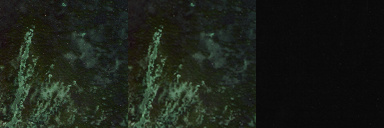

/workspace/satlas//val_set/naip/m_2408122_ne_17_060_20191128/35944_56235/rgb.png (128, 128, 3) (128, 128, 4)



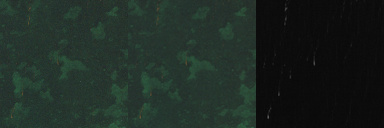

/workspace/satlas//val_set/naip/m_2408127_ne_17_060_20191128/35803_56299/rgb.png (128, 128, 3) (128, 128, 4)



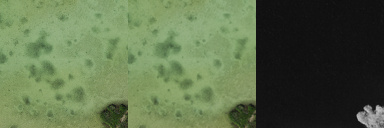

In [85]:
print("Results for resampling_method:", resampling_method)
for k, v in vis_result.items():
    orig_bgr = cv2.imread(k)
    show_nir = cv2.cvtColor(v[:,:,3], cv2.COLOR_GRAY2BGR)
    show_line = np.hstack([orig_bgr,v[:,:,:3][:,:,::-1], show_nir])
    print(k, orig_bgr.shape, v.shape)
    show_jpg(show_line)

In [94]:
#The `geo_to_mercator` and `mercator_to_geo` functions in `satlas.util` translate from tile coordinates like (1867, 3287) to longitude-latitude coordinates like (33.4681, -97.9541).
# testing code from satlas repo
# adapted from https://github.com/allenai/satlas/satlas/util/__init__.py
def mercator_to_geo(p, zoom, pixels):
    n = 2**zoom
    x = p[0] / pixels
    y = p[1] / pixels
    x = x * 360.0 / n - 180
    y = math.atan(math.sinh(math.pi * (1 - 2.0 * y / n)))
    y = y * 180 / math.pi
    return (x, y)

def interpolate_corners(tile, pixels=128, zoom=17): # x/y coordinates in EPSG:4326 (WGS84)
    c1 = mercator_to_geo(tile, zoom=zoom, pixels=1)  # upper left
    c2 = mercator_to_geo((tile[0] * pixels + pixels, tile[1]), zoom=zoom, pixels=pixels)  # upper right
    c3 = mercator_to_geo((tile[0], tile[1] * pixels - pixels), zoom=zoom, pixels=pixels)  # bottom left
    c4 = mercator_to_geo((tile[0] * pixels + pixels, tile[1] * pixels - pixels), zoom=zoom, pixels=pixels)  # bottom right
    a=np.linspace(c1, c2, pixels)
    b=np.linspace(c3, c4, pixels)
    c = np.array([np.linspace(i, j, pixels) for i,j in zip(a,b)])  # [512, 512, 2]
    return c

from rasterio.transform import rowcol
from rasterio.warp import transform
src = rasterio.open(load_path)
wgs84_coords = interpolate_corners(xy)
xs, ys = transform("EPSG:4326", src.crs,  wgs84_coords[:,:,0].flatten(), wgs_coords[:,:,1].flatten())
raster_coords = list(zip(xs,ys))
results = list(src.sample(raster_coords))
test_res = np.array(results).reshape(4,-1).reshape(4, 128,128)
got_rgb = np.ascontiguousarray(np.transpose(test_res,(1,2,0))[:,:,:3][:,:,::-1])
#showim(got_rgb)

In [ ]:
#{0: 3.8192403,
# 0.4186452654937383: 5.1353526,
# 0.5: 5.7058425,
# 1.0: 9.382289,
# 1.5: 12.095038,
# 2.0: 13.970809,
# 2.388657133911758: 15.090391}
def webmercator2bbox4326(x,y,z):
    tile = mercantile.Tile(x=x, y=y, z=z)
    return  mercantile.bounds(tile) # EPSG:4326 (WGS84)
